<a href="https://colab.research.google.com/github/tamara-kostova/IIS/blob/master/recommender_lastfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd

artists_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/artists.dat', sep='\t', header=None, names=['id', 'name', 'url', 'pictureURL'])
tags_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/tags.dat', sep='\t', header=None, names=['tagID', 'tagValue'], encoding='latin-1')
user_artists_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_artists.dat', sep='\t', header=None, names=['userID', 'artistID', 'weight'])
user_taggedartists_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_taggedartists.dat', sep='\t', header=None, names=['userID', 'artistID', 'tagID', 'day', 'month', 'year'])
user_friends_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_friends.dat', sep='\t', header=None, names=['userID', 'friendID'])

<ipython-input-1-750f1cc22fdd>:6: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  user_taggedartists_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_taggedartists.dat', sep='\t', header=None, names=['userID', 'artistID', 'tagID', 'day', 'month', 'year'])


In [ ]:
artists_df.head()

,id,name,url,pictureURL
0,id,name,url,pictureURL
1,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
2,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
3,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
4,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...


In [ ]:
artists_df.describe()

,id,name,url,pictureURL
count,17633,17633,17633,17189
unique,17633,17633,17633,17189
top,id,name,url,pictureURL
freq,1,1,1,1


In [ ]:
user_artists_df.head()

,userID,artistID,weight
0,userID,artistID,weight
1,2,51,13883
2,2,52,11690
3,2,53,11351
4,2,54,10300


In [ ]:
user_artists_df.describe()

,userID,artistID,weight
count,92835,92835,92835
unique,1893,17633,5437
top,1030,89,1
freq,50,611,636


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

### Distribution of Users' Listening Counts

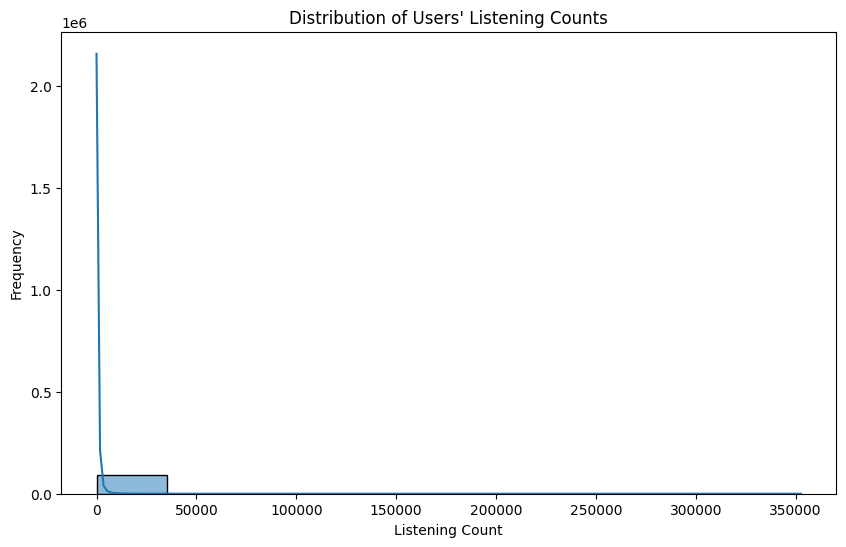

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(user_artists_df['weight'], bins=10, kde=True)
plt.title("Distribution of Users' Listening Counts")
plt.xlabel('Listening Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

In [ ]:
user_artists_df = user_artists_df[user_artists_df['weight'].apply(is_numeric)]

In [ ]:
user_artists_df['weight'] = user_artists_df['weight'].astype(float)

<ipython-input-4-e9cc85b330ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_artists_df['weight'] = user_artists_df['weight'].astype(float)


### Top 10 Most Listened Artists

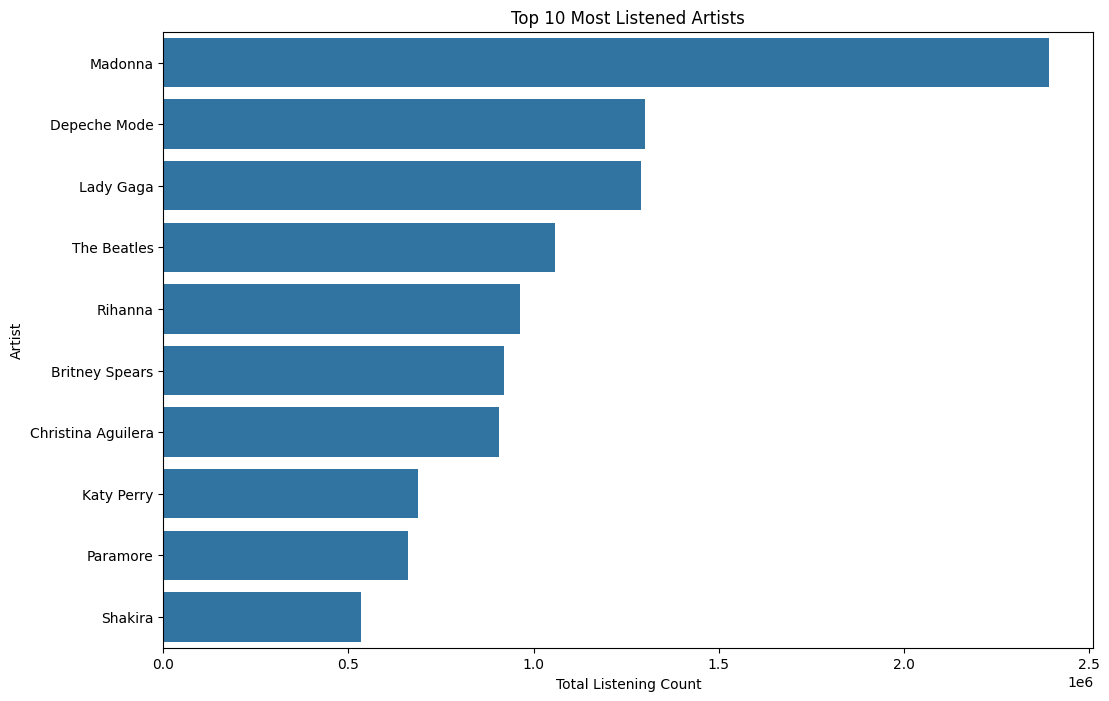

In [ ]:
top_artists = user_artists_df.groupby('artistID')['weight'].sum().sort_values(ascending=False).head(10)
top_artists_names = artists_df[artists_df['id'].isin(top_artists.index)]['name']

plt.figure(figsize=(12, 8))
sns.barplot(x=top_artists.values, y=top_artists_names)
plt.title('Top 10 Most Listened Artists')
plt.xlabel('Total Listening Count')
plt.ylabel('Artist')
plt.show()

### User Friendships Network

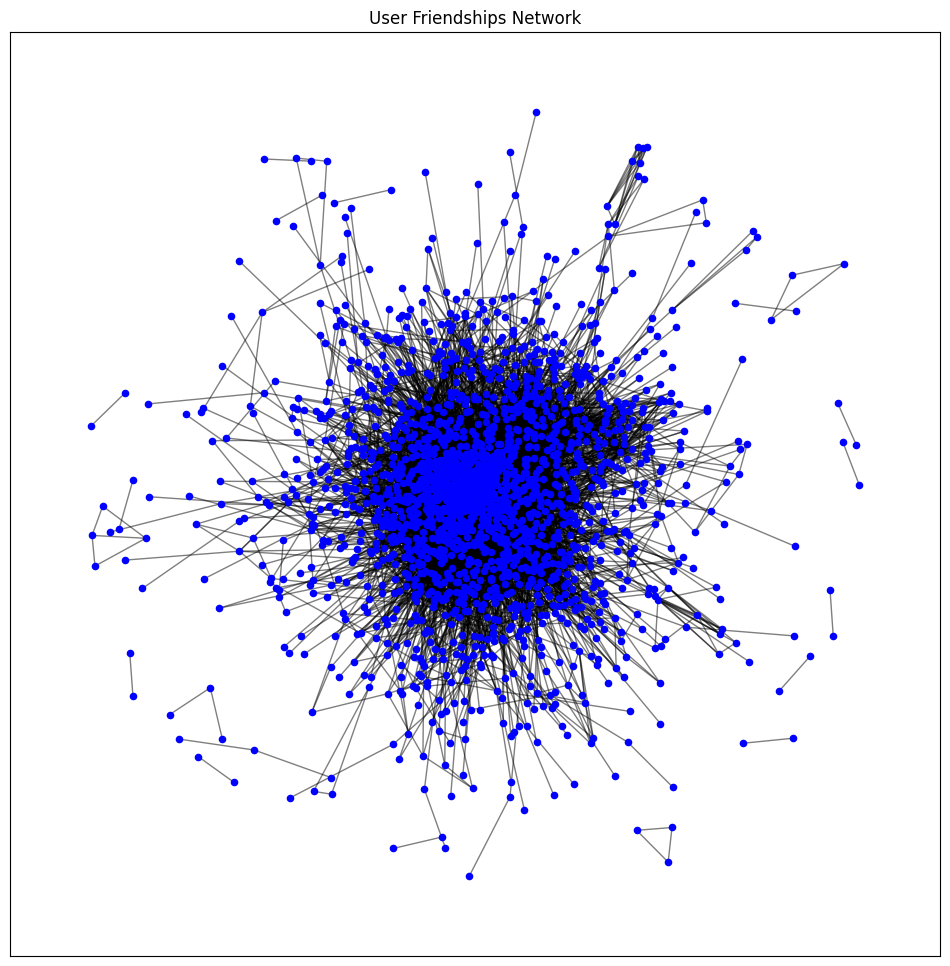

In [ ]:
G = nx.from_pandas_edgelist(user_friends_df, 'userID', 'friendID')

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='blue')
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('User Friendships Network')
plt.show()

### Heatmap of User-Artist Interactions

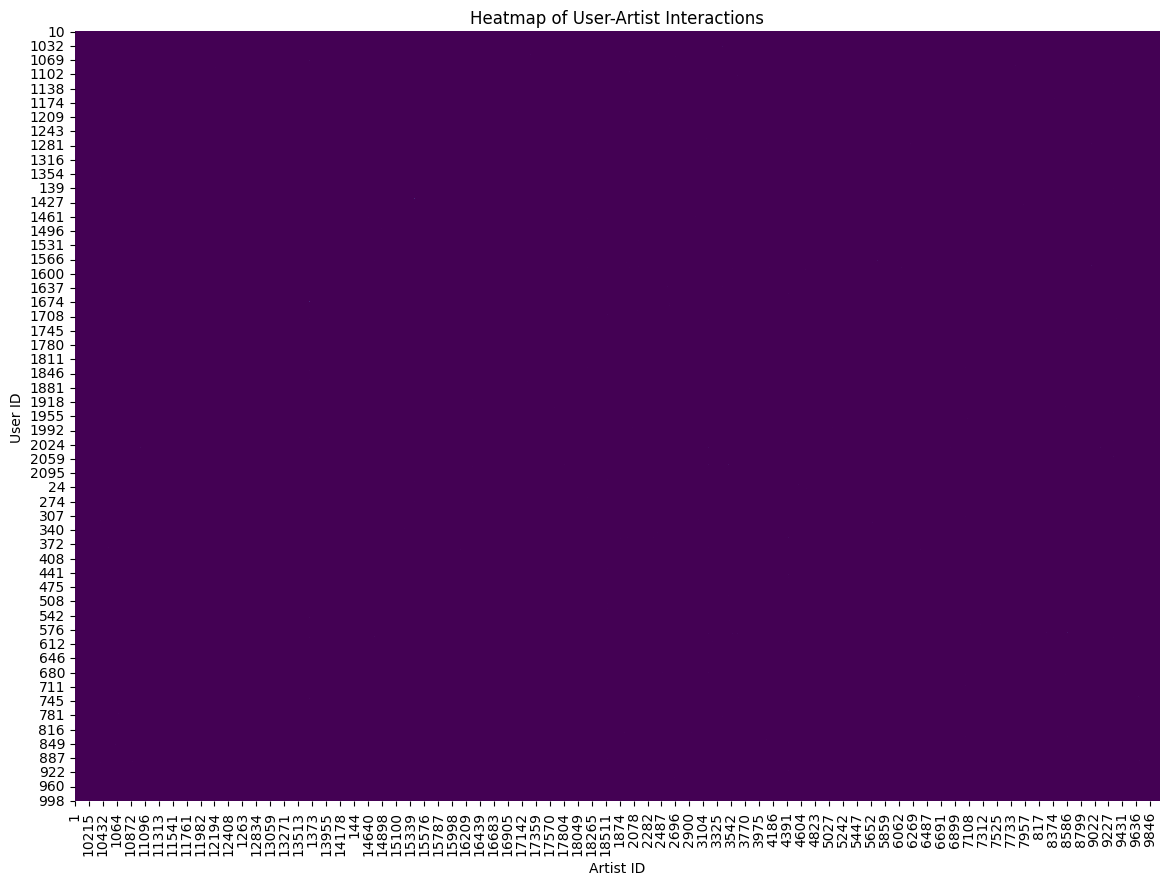

In [ ]:
interaction_matrix = user_artists_df.pivot(index='userID', columns='artistID', values='weight').fillna(0)

plt.figure(figsize=(14, 10))
sns.heatmap(interaction_matrix, cmap='viridis', cbar=False)
plt.title('Heatmap of User-Artist Interactions')
plt.xlabel('Artist ID')
plt.ylabel('User ID')
plt.show()

# Graph

In [ ]:
!pip install networkx

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
G = nx.Graph()

In [ ]:
users = set(user_artists_df['userID']).union(set(user_friends_df['userID']))
artists = set(user_artists_df['artistID'])
tags = set(user_taggedartists_df['tagID'])

In [ ]:
def clean_edge_weights(G):
    for u, v, data in G.edges(data=True):
        if 'weight' in data:
            try:
                data['weight'] = float(data['weight'])
            except ValueError:
                # Remove edge if weight is not numeric
                G.remove_edge(u, v)
                print(f"Removed edge ({u}, {v}) with invalid weight: {data['weight']}")

## Add nodes

### users

In [ ]:
G.add_nodes_from(users, bipartite=0, type='user')

### artists

In [ ]:
G.add_nodes_from(artists, bipartite=1, type='artist')

### tags

In [ ]:
# G.add_nodes_from(tags, bipartite=2, type='tag')

## Add edges

In [ ]:
for _, row in user_artists_df.iterrows():
    G.add_edge(row['userID'], row['artistID'], weight=float(row['weight']), relation='listens')

In [ ]:
for _, row in user_friends_df.iterrows():
    G.add_edge(row['userID'], row['friendID'], relation='friends')

In [ ]:
for _, row in user_taggedartists_df.iterrows():
    G.add_edge(row['userID'], row['tagID'], relation='tags')
    G.add_edge(row['tagID'], row['artistID'], relation='tags')

# Visualization

In [ ]:
clean_edge_weights(G)

Removed edge (userID, artistID) with invalid weight: weight


RuntimeError: dictionary changed size during iteration

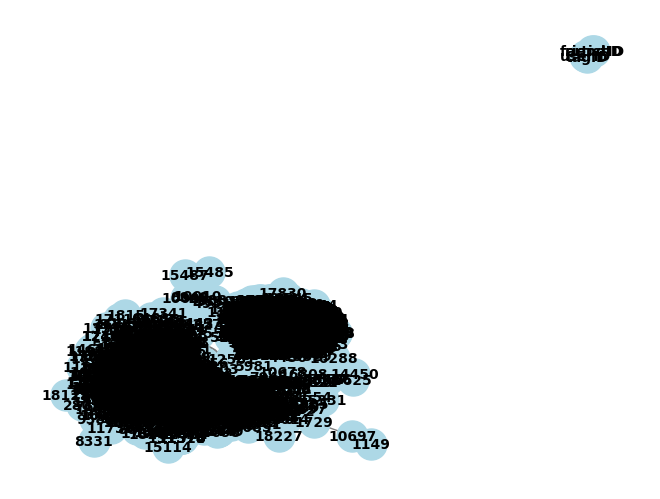

In [ ]:
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10, font_weight='bold')
plt.show()

In [ ]:
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
default_node_attrs = {'type': 'unknown'}

# Check all nodes and add missing attributes with default values
for node in G.nodes():
    for attr in default_node_attrs:
        if attr not in G.nodes[node]:
            G.nodes[node][attr] = default_node_attrs[attr]

# Set attributes for users and artists
for user in users:
    G.nodes[user]['type'] = 'user'

for artist in artists:
    G.nodes[artist]['type'] = 'artist'

# for tag in tags:
#   G.nodes[tag]['type'] = 'tag'

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx

In [ ]:
G.nodes(data=True)

NodeDataView({'225': {'bipartite': 2, 'type': 'tag'}, '1596': {'bipartite': 2, 'type': 'tag'}, '508': {'bipartite': 2, 'type': 'tag'}, '294': {'bipartite': 2, 'type': 'tag'}, '1933': {'bipartite': 2, 'type': 'tag'}, '154': {'bipartite': 1, 'type': 'artist'}, '1016': {'bipartite': 2, 'type': 'tag'}, '1290': {'bipartite': 2, 'type': 'tag'}, '1936': {'bipartite': 2, 'type': 'tag'}, '312': {'bipartite': 2, 'type': 'tag'}, '1330': {'bipartite': 2, 'type': 'tag'}, '1440': {'bipartite': 2, 'type': 'tag'}, '405': {'bipartite': 2, 'type': 'tag'}, '545': {'bipartite': 2, 'type': 'tag'}, '1671': {'bipartite': 2, 'type': 'tag'}, '1774': {'bipartite': 2, 'type': 'tag'}, '1860': {'bipartite': 2, 'type': 'tag'}, '1990': {'bipartite': 2, 'type': 'tag'}, '1159': {'bipartite': 2, 'type': 'tag'}, '1332': {'bipartite': 2, 'type': 'tag'}, '1994': {'bipartite': 2, 'type': 'tag'}, '1835': {'bipartite': 2, 'type': 'tag'}, '1258': {'bipartite': 1, 'type': 'artist'}, '1120': {'bipartite': 1, 'type': 'artist'}, 

In [ ]:
pyg_data = from_networkx(G)

In [ ]:
pyg_data

Data(edge_index=[2, 184760], bipartite=[17645], type=[17645], weight=[184760], relation=[184760], num_nodes=17645)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
from torch import optim

model = GCN()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Create a mask for training/validation split if needed
train_mask = torch.zeros(pyg_data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(pyg_data.num_nodes, dtype=torch.bool)

num_nodes = pyg_data.num_nodes
num_train = int(0.8 * num_nodes)
train_mask[:num_train] = True
val_mask[num_train:] = True

# Add masks to the data
pyg_data.train_mask = train_mask
pyg_data.val_mask = val_mask

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(pyg_data.x, pyg_data.edge_index)
    loss = F.cross_entropy(out, pyg_data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
def test():
    model.eval()
    out = model(pyg_data)
    pred = out.argmax(dim=1)
    correct = pred[pyg_data.val_mask] == labels[pyg_data.val_mask]
    accuracy = int(correct.sum()) / pyg_data.val_mask.sum()
    return accuracy

In [ ]:
import torch

# Dummy features (you can use actual features if available)
num_nodes = pyg_data.num_nodes
num_features = 1  # Example: one feature per node
pyg_data.x = torch.ones((num_nodes, num_features))

# Create labels based on 'type' attribute
node_types = [G.nodes[node]['type'] for node in G.nodes()]
labels = torch.zeros(num_nodes, dtype=torch.long)

# Map 'user' to 0 and 'artist' to 1
for i, node_type in enumerate(node_types):
    if node_type == 'user':
        labels[i] = 0
    elif node_type == 'artist':
        labels[i] = 1

# Attach labels to PyG Data object (if needed)
pyg_data.y = labels

# Ensure correct size and dtype
print(labels)

tensor([1, 1, 1,  ..., 1, 1, 1])


In [ ]:
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

Epoch 0, Loss: 0.6264
Epoch 10, Loss: 0.3775
Epoch 20, Loss: 0.2018
Epoch 30, Loss: 0.0997
Epoch 40, Loss: 0.0526
Epoch 50, Loss: 0.0328
Epoch 60, Loss: 0.0241
Epoch 70, Loss: 0.0198
Epoch 80, Loss: 0.0175
Epoch 90, Loss: 0.0161
Epoch 100, Loss: 0.0152
Epoch 110, Loss: 0.0146
Epoch 120, Loss: 0.0141
Epoch 130, Loss: 0.0138
Epoch 140, Loss: 0.0135
Epoch 150, Loss: 0.0133
Epoch 160, Loss: 0.0132
Epoch 170, Loss: 0.0130
Epoch 180, Loss: 0.0129
Epoch 190, Loss: 0.0129


In [ ]:
artist_id_to_name = pd.Series(artists_df['name'].values, index=artists_df['id']).to_dict()

In [ ]:
artist_id_to_name

{'id': 'name',
 '1': 'MALICE MIZER',
 '2': 'Diary of Dreams',
 '3': 'Carpathian Forest',
 '4': 'Moi dix Mois',
 '5': 'Bella Morte',
 '6': 'Moonspell',
 '7': 'Marilyn Manson',
 '8': 'DIR EN GREY',
 '9': 'Combichrist',
 '10': 'Grendel',
 '11': 'Agonoize',
 '12': 'Behemoth',
 '13': 'Hocico',
 '15': 'Dimmu Borgir',
 '16': 'London After Midnight',
 '17': 'Psyclon Nine',
 '18': 'The Crüxshadows',
 '19': ':wumpscut:',
 '20': 'Limbonic Art',
 '21': 'Artista sconosciuto',
 '22': 'xotox',
 '23': 'The Kovenant',
 '24': 'Feindflug',
 '25': 'Cradle of Filth',
 '26': 'Tamtrum',
 '27': 'Laibach',
 '28': 'Gorgoroth',
 '30': 'And One',
 '31': 'Amduscia',
 '32': 'Covenant',
 '34': 'Icon of Coil',
 '36': 'KMFDM',
 '37': 'Funker Vogt',
 '38': 'Dawn of Ashes',
 '39': 'Sopor Aeternus & The Ensemble of Shadows',
 '40': 'The Faint',
 '41': 'God Module',
 '43': 'Noisuf-X',
 '44': 'Das Ich',
 '45': 'Mindless Self Indulgence',
 '46': 'Pyotr Ilyich Tchaikovsky',
 '47': 'Emperor',
 '48': 'Anorexia Nervosa',
 '49':

In [ ]:
import numpy as np

def get_recommendations(user_ids, top_k=5):
    model.eval()
    with torch.no_grad():
        # Compute embeddings
        out = model(pyg_data.x, pyg_data.edge_index)

        # Convert embeddings to numpy array
        embeddings = out.numpy()

        # Get user and artist node indices
        user_indices = [node for node in G.nodes if G.nodes[node]['type'] == 'user']
        artist_indices = [node for node in G.nodes if G.nodes[node]['type'] == 'artist']

        # Ensure indices are integers
        user_ids = [int(uid) for uid in user_ids]
        artist_indices = [int(aid) for aid in artist_indices]

        # Check if indices are within the range of embeddings
        max_index = embeddings.shape[0] - 1
        user_ids = [uid for uid in user_ids if 0 <= uid <= max_index]
        artist_indices = [aid for aid in artist_indices if 0 <= aid <= max_index]

        # Create a dictionary to store recommendations
        recommendations = {}

        for user in user_ids:
            if user >= len(embeddings):
                continue
            user_embedding = embeddings[user]
            similarities = []

            for artist in artist_indices:
                if artist >= len(embeddings):
                    continue
                artist_embedding = embeddings[artist]
                sim = np.dot(user_embedding, artist_embedding) / (np.linalg.norm(user_embedding) * np.linalg.norm(artist_embedding))
                similarities.append((artist, sim))

            # Sort artists by similarity
            similarities.sort(key=lambda x: x[1], reverse=True)

            # Get top K recommendations
            top_artists = [artist for artist, _ in similarities[:top_k]]
            # recommendations[user] = top_artists

            top_artists_names = [artist_id_to_name.get(artist, 'Unknown') for artist in top_artists]
            recommendations[user] = top_artists

        return recommendations

In [ ]:
node_to_artist = {node: artist for node, data in G.nodes(data=True) if data['type'] == 'artist'}

In [ ]:
recommendations = get_recommendations([2])
print(recommendations)

{2: [2031, 1667, 681, 5667, 4260]}


In [ ]:
artists_df = artists_df[artists_df['id'].apply(lambda x: str(x).isnumeric())]
artists_df['id'] = artists_df['id'].astype(int)

# Create a dictionary mapping artist IDs to names
artist_id_to_name = pd.Series(artists_df['name'].values, index=artists_df['id']).to_dict()

# Function to map recommendations to artist names
def map_recommendations(recommendations):
    mapped_recommendations = {user_id: [artist_id_to_name.get(artist_id, 'Unknown') for artist_id in artist_ids] for user_id, artist_ids in recommendations.items()}
    return mapped_recommendations

<ipython-input-42-555407eb4991>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artists_df['id'] = artists_df['id'].astype(int)


In [ ]:
mapped_recommendations = map_recommendations(recommendations)

print(mapped_recommendations)

{2: ['Bee Gees', 'Mike Ness', 'Demi Lovato', 'The Agonist', 'Julieta Venegas']}
